In [1]:
import os
import numpy as np
import scipy.io as sio
import torch
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np
import random

def set_seed(seed):
    """
    Set seed for reproducibility across various libraries.
    """
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # No explicit MPS-specific seed setting; torch.manual_seed covers it.
        pass
    else:
        torch.cuda.manual_seed_all(seed)  # For CUDA devices
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a specific seed value
set_seed(42)

# Ensure device compatibility
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
# Define main folder path
MAIN_FOLDER_PATH = '/Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/'

In [4]:
# Function to load .mat data
def load_mat_data(data_path: str):
    try:
        mat_data = sio.loadmat(data_path)
        print("Data loaded successfully.")
        return mat_data
    except FileNotFoundError:
        print(f"File not found at path: {data_path}")
        return {}
    except Exception as e:
        print(f"Error loading data: {e}")
        return {}

In [5]:
# Function to extract data from .mat structure
def extract_data(mat_data: dict):
    if 'myData' in mat_data:
        try:
            data = np.abs(mat_data['myData']['LTF'][0, 0])  # Extracting 'LTF' field
            labels = mat_data['myData']['label'][0, 0]     # Extracting 'label' field
            print("Data and labels extracted successfully.")
            return data, labels
        except KeyError as e:
            print(f"KeyError: {e} - Check if 'LTF' or 'label' exists in 'myData'.")
    else:
        print("Key 'myData' not found in loaded .mat file.")
    return None, None

In [6]:
# Function to plot sample signals
def plot_sample_signals(data, indices, output_folder):
    if data is None or data.shape[0] < max(indices):  # Ensure sufficient rows
        print("Data is not available or too small for plotting.")
        return

    fig, axs = plt.subplots(len(indices), 1, figsize=(10, 8))
    titles = [
        f"Sample Signal of Tx{i + 1} @index {idx}" for i, idx in enumerate(indices)
    ]

    for i, idx in enumerate(indices):
        if idx >= data.shape[0]:
            print(f"Index {idx} is out of bounds for data with shape {data.shape}.")
            axs[i].text(0.5, 0.5, f"Data index {idx} out of bounds", ha='center')
            continue
        axs[i].plot(data[idx, :])
        axs[i].set_ylabel("Freq")
        axs[i].set_title(titles[i])

    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    output_path = os.path.join(output_folder, 'WaveFormSample.jpg')
    os.makedirs(output_folder, exist_ok=True)  # Ensure directory exists
    plt.savefig(output_path)
    plt.show()

In [7]:
# Function to split data into classes
def split_data(data, slices):
    class_data = {}
    try:
        for name, (start, end) in slices.items():
            class_data[name] = data[start:end, :]
        print("Data has been split into classes successfully.")
        return class_data
    except IndexError as e:
        print(f"IndexError: {e} - Verify the shape of 'data'.")
        return None

In [8]:
# Function to save class data
def save_class_data(class_data, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for class_name, class_array in class_data.items():
        subfolder_path = os.path.join(output_folder, class_name)
        os.makedirs(subfolder_path, exist_ok=True)
        output_file_path = os.path.join(subfolder_path, f"{class_name}.npy")
        np.save(output_file_path, class_array)
        print(f"Saved data for class '{class_name}' to {output_file_path}.")

In [9]:
# Min-Max Scaling Function
def min_max_scaling(data, feature_range=(0, 1)):
    min_val, max_val = feature_range
    data_min = np.min(data, axis=1, keepdims=True)
    data_max = np.max(data, axis=1, keepdims=True)
    range_diff = data_max - data_min
    range_diff[range_diff == 0] = 1e-8  # Avoid division by zero
    scaled_data = (data - data_min) / range_diff
    return scaled_data * (max_val - min_val) + min_val

In [10]:
# Normalize class data
def normalize_class_data(class_data):
    normalized_data = {}
    for class_name, class_array in class_data.items():
        normalized_data[class_name] = min_max_scaling(class_array)
        print(f"Class {class_name} normalized successfully.")
    return normalized_data

In [11]:
from sklearn.model_selection import train_test_split

# Function to split data into training and validation sets
def split_train_test(normalized_class_data, test_size=0.2, random_state=42):
    """
    Split the normalized data into training and validation sets.

    Args:
        normalized_class_data (dict): Dictionary of class data (each as a numpy array).
        test_size (float): Proportion of the data to be used as the test set (default is 0.2).
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Training data split by class.
        dict: Validation data split by class.
    """
    train_data = {}
    test_data = {}

    for class_name, class_array in normalized_class_data.items():
        train, test = train_test_split(
            class_array, test_size=test_size, random_state=random_state
        )
        train_data[class_name] = train
        test_data[class_name] = test
        print(f"Class {class_name}: Train size = {train.shape[0]}, Test size = {test.shape[0]}")
    
    return train_data, test_data

In [12]:
def add_awgn(data, snr_db):
    """
    Add Additive White Gaussian Noise (AWGN) to the data.

    Args:
        data (numpy.ndarray): The original signal data.
        snr_db (float): Desired Signal-to-Noise Ratio (SNR) in decibels.

    Returns:
        numpy.ndarray: Signal with AWGN added.
    """
    # Calculate signal power
    signal_power = np.mean(data ** 2, axis=1, keepdims=True)

    # Calculate noise power based on SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise
    noise = np.sqrt(noise_power) * np.random.randn(*data.shape)

    # Add noise to the signal
    noisy_data = data + noise
    return noisy_data

In [13]:
# Add AWGN to training data
def add_awgn_to_training_data(train_data, snr_db):
    """
    Add AWGN to all training data classes.

    Args:
        train_data (dict): Dictionary of training data split by class.
        snr_db (float): Desired Signal-to-Noise Ratio (SNR) in decibels.

    Returns:
        dict: Training data with AWGN added.
    """
    noisy_train_data = {}
    for class_name, class_array in train_data.items():
        noisy_train_data[class_name] = add_awgn(class_array, snr_db)
        print(f"Added AWGN to class {class_name} with SNR = {snr_db} dB.")
    return noisy_train_data

In [14]:
import pywt

# Function to apply DWT multiresolution analysis
def apply_dwt_multiresolution(data, wavelet='db1', level=3):
    """
    Apply DWT multiresolution analysis to the data.

    Args:
        data (numpy.ndarray): Input signal data (2D array: samples x time).
        wavelet (str): Wavelet type (default is 'db1').
        level (int): Level of decomposition (default is 3).

    Returns:
        list of numpy.ndarray: Approximation coefficients and details at each level.
    """
    dwt_coefficients = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
        dwt_coefficients.append(coeffs)
    return dwt_coefficients

In [15]:
# Apply DWT to noisy training data
def apply_dwt_to_noisy_training_data(noisy_train_data, wavelet='db1', level=3):
    """
    Apply DWT multiresolution analysis to all noisy training data classes.

    Args:
        noisy_train_data (dict): Dictionary of noisy training data split by class.
        wavelet (str): Wavelet type (default is 'db1').
        level (int): Level of decomposition (default is 3).

    Returns:
        dict: DWT coefficients for each class.
    """
    dwt_data = {}
    for class_name, class_array in noisy_train_data.items():
        dwt_data[class_name] = apply_dwt_multiresolution(class_array, wavelet=wavelet, level=level)
        print(f"Applied DWT to class {class_name} with wavelet '{wavelet}' and level {level}.")
    return dwt_data

In [16]:
# Save DWT coefficients
def save_dwt_data(dwt_data, output_folder):
    """
    Save DWT coefficients to disk.

    Args:
        dwt_data (dict): Dictionary of DWT coefficients split by class.
        output_folder (str): Folder to save the data.
    """
    os.makedirs(output_folder, exist_ok=True)
    for class_name, coeffs in dwt_data.items():
        output_file_path = os.path.join(output_folder, f"{class_name}_dwt.npy")
        np.save(output_file_path, coeffs)
        print(f"Saved DWT coefficients for class '{class_name}' to {output_file_path}.")

In [17]:
def create_triplets(dwt_data, num_triplets=10000, level=0):
    """
    Create triplets (anchor, positive, negative) from the given data.

    Args:
        dwt_data (dict): Dictionary of DWT coefficients split by class.
        num_triplets (int): Number of triplets to generate.
        level (int): Level of DWT coefficients to use as input (default is 0).

    Returns:
        list of tuples: Each tuple contains (anchor, positive, negative).
        list: Corresponding ground-truth labels (class of anchor and positive).
    """
    triplets = []
    labels = []
    class_names = list(dwt_data.keys())

    for _ in range(num_triplets):
        # Randomly select an anchor class
        anchor_class = np.random.choice(class_names)
        positive_class = anchor_class  # Positive comes from the same class
        negative_class = np.random.choice([cls for cls in class_names if cls != anchor_class])

        # Randomly select anchor and positive samples from the same class
        anchor_coeffs = dwt_data[anchor_class]
        positive_coeffs = dwt_data[positive_class]
        anchor_sample, positive_sample = np.random.choice(len(anchor_coeffs), size=2, replace=False)

        # Extract coefficients at the specified level for anchor and positive
        anchor = anchor_coeffs[anchor_sample][level]
        positive = positive_coeffs[positive_sample][level]

        # Randomly select a negative sample from a different class
        negative_coeffs = dwt_data[negative_class]
        negative_sample = np.random.choice(len(negative_coeffs))
        negative = negative_coeffs[negative_sample][level]

        # Append triplet and label
        triplets.append((anchor, positive, negative))
        labels.append(anchor_class)  # Use anchor's class as the label

    return triplets, labels

In [18]:
# Save triplets and labels
def save_triplets(triplets, labels, output_folder):
    """
    Save triplets and labels to disk.

    Args:
        triplets (list of tuples): List of triplets (anchor, positive, negative).
        labels (list): Corresponding ground-truth labels.
        output_folder (str): Folder to save the data.
    """
    os.makedirs(output_folder, exist_ok=True)
    triplets_path = os.path.join(output_folder, "triplets.npy")
    labels_path = os.path.join(output_folder, "labels.npy")

    np.save(triplets_path, triplets)
    np.save(labels_path, labels)
    print(f"Saved triplets to {triplets_path} and labels to {labels_path}.")


Data loaded successfully.
Data and labels extracted successfully.


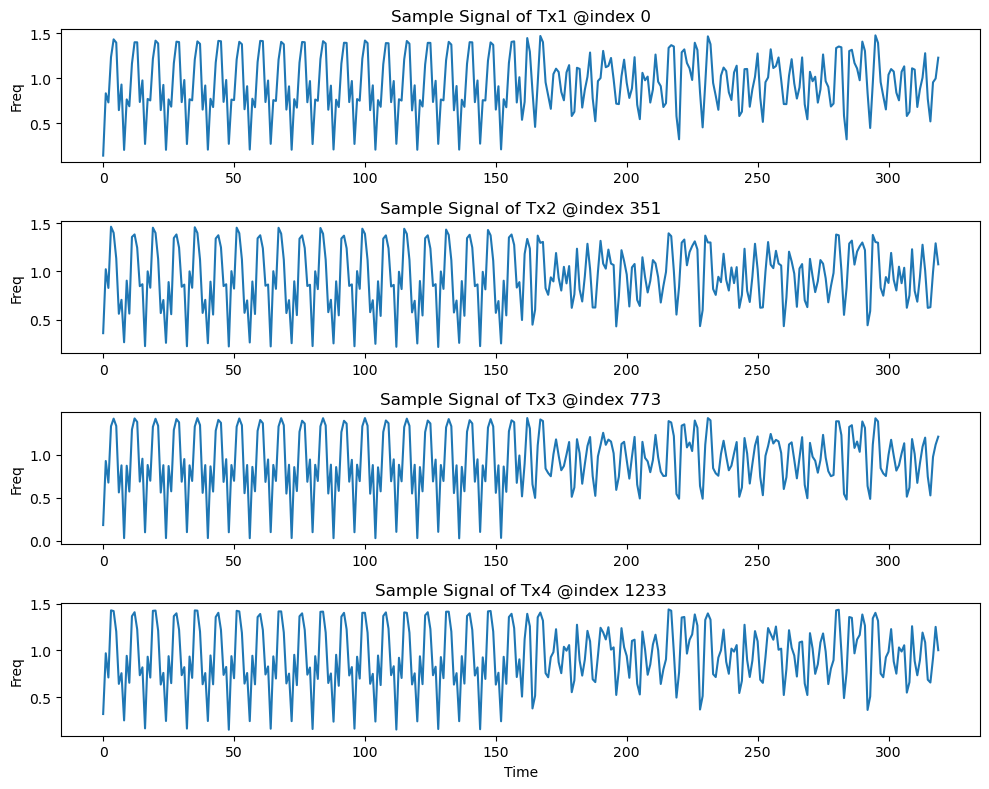

Data has been split into classes successfully.
Saved data for class 'txa1a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txa1a/txa1a.npy.
Saved data for class 'txb2a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txb2a/txb2a.npy.
Saved data for class 'txc3a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txc3a/txc3a.npy.
Saved data for class 'txd4a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txd4a/txd4a.npy.
Saved data for class 'txe5a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txe5a/txe5a.npy.
Saved data for class 'txf6a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txf6a/txf6a.npy.
Saved data for class 'txg7a' to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTxdataset/txg7a/txg7a.npy.
Saved data for class 'txh8a' to /Users/sarkorjonku

/opt/miniconda3/envs/DWT_pytorch_env/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Saved triplets to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTx_triplets/triplets.npy and labels to /Users/sarkorjonkurbonov/projects/DWT_pytorch/AWGN_DWT_TripleLoss/wifiTx_triplets/labels.npy.


In [19]:
# Main program
if __name__ == "__main__":
    data_path = os.path.join(MAIN_FOLDER_PATH, 'myData.mat')
    mat_data = load_mat_data(data_path)

    # Extract data
    data, labels = extract_data(mat_data)

    # Plot sample signals
    plot_indices = [0, 351, 773, 1233]  # Change as needed
    plot_sample_signals(data, plot_indices, MAIN_FOLDER_PATH)

    # Define slices for data splitting
    slices = {
        'txa1a': (0, 350),
        'txb2a': (351, 701),
        'txc3a': (773, 1123),
        'txd4a': (1233, 1583),
        'txe5a': (1622, 1972),
        'txf6a': (2024, 2374),
        'txg7a': (2477, 2827),
        'txh8a': (2915, 3265),
        'txi9a': (3365, 3715),
        'txj10a': (3760, 4110),
        'txk11a': (4224, 4574),
    }

    class_data = split_data(data, slices)

    # Save class data
    dataset_folder = os.path.join(MAIN_FOLDER_PATH, 'wifiTxdataset')
    save_class_data(class_data, dataset_folder)

    # Normalize class data
    normalized_class_data = normalize_class_data(class_data)

    # Verify normalization
    for class_name, class_array in normalized_class_data.items():
        print(f"Class {class_name} -> Min: {np.min(class_array)}, Max: {np.max(class_array)}")

    # Split normalized data into training and validation sets
    train_data, test_data = split_train_test(normalized_class_data, test_size=0.2)

    # Add AWGN to training data with SNR = 0 dB
    snr_db = 0
    noisy_train_data = add_awgn_to_training_data(train_data, snr_db)

    # Apply DWT to noisy training data
    dwt_folder = os.path.join(MAIN_FOLDER_PATH, 'wifiTx_dwt_train')
    dwt_data = apply_dwt_to_noisy_training_data(noisy_train_data, wavelet='db1', level=3)
    save_dwt_data(dwt_data, dwt_folder)

    # Create triplets
    triplets, triplet_labels = create_triplets(dwt_data, num_triplets=10000, level=0)

    # Save triplets and labels
    triplets_folder = os.path.join(MAIN_FOLDER_PATH, 'wifiTx_triplets')
    save_triplets(triplets, triplet_labels, triplets_folder)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseCNN(nn.Module):
    def __init__(self, num_classes=11, embedding_dim=128):
        super(SiameseCNN, self).__init__()
        
        # Shared feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm1d(128),  # Add this
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        # Embedding layer
        self.embedding_layer = nn.Sequential(
            nn.Linear(128, embedding_dim),
            nn.Dropout(0.5)  # Dropout rate of 50%
        )
        
        # Classification head
        self.classification_head = nn.Linear(embedding_dim, num_classes)

    def forward_once(self, x):
        """
        Forward pass for one branch of the Siamese network.
        """
        features = self.feature_extractor(x)
        embedding = self.embedding_layer(features)
        embedding = F.normalize(embedding, p=2, dim=1)  # Normalize embeddings
        return embedding

    def forward(self, anchor, positive, negative):
        """
        Forward pass for the triplet inputs.
        """
        anchor_embedding = self.forward_once(anchor)
        positive_embedding = self.forward_once(positive)
        negative_embedding = self.forward_once(negative)
        return anchor_embedding, positive_embedding, negative_embedding

    def classify(self, x):
        """
        Classification output from embeddings.
        """
        embedding = self.forward_once(x)
        logits = self.classification_head(embedding)
        return logits

In [21]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Compute triplet loss.
        """
        pos_distance = F.pairwise_distance(anchor, positive, p=2)
        neg_distance = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()


def train_siamese_with_triplet_loss(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch_idx, (anchor, positive, negative, _) in enumerate(train_loader):
        # Move data to the appropriate device
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Forward pass
        anchor_embed, positive_embed, negative_embed = model(anchor, positive, negative)
        
        # Compute triplet loss
        loss = criterion(anchor_embed, positive_embed, negative_embed)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [22]:
def fine_tune_for_classification(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass for classification
        logits = model.classify(inputs)
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [23]:
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, triplets, labels):
        self.triplets = triplets
        self.labels = labels

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        label = self.labels[idx]
        # Convert to tensors
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        positive = torch.tensor(positive, dtype=torch.float32).unsqueeze(0)
        negative = torch.tensor(negative, dtype=torch.float32).unsqueeze(0)
        return anchor, positive, negative, label


class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_data, label

In [24]:
# Hyperparameters
embedding_dim = 128
num_classes = 11
margin = 1.0
learning_rate = 0.001
batch_size = 64
num_epochs_triplet = 20
num_epochs_classification = 20


# Generate classification dataset from the training data
def generate_classification_data(train_data):
    """
    Prepare classification data and labels from the training data.

    Args:
        train_data (dict): Dictionary with class names as keys and samples as values.

    Returns:
        tuple: (classification_data, classification_labels)
    """
    classification_data = []
    classification_labels = []
    class_to_idx = {class_name: idx for idx, class_name in enumerate(train_data.keys())}

    for class_name, samples in train_data.items():
        for sample in samples:
            classification_data.append(sample)
            classification_labels.append(class_to_idx[class_name])

    return np.array(classification_data), np.array(classification_labels), class_to_idx


# Generate classification data
classification_data, classification_labels, class_to_idx = generate_classification_data(train_data)

# Initialize classification dataset
classification_dataset = ClassificationDataset(classification_data, classification_labels)

# Initialize DataLoader for classification
classification_loader = DataLoader(classification_dataset, batch_size=batch_size, shuffle=True)
# Prepare datasets and dataloaders
triplet_dataset = TripletDataset(triplets, triplet_labels)
classification_dataset = ClassificationDataset(classification_data, classification_labels)

triplet_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)
classification_loader = DataLoader(classification_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss functions, and optimizer
model = SiameseCNN(num_classes=num_classes, embedding_dim=embedding_dim).to(device)
triplet_criterion = TripletLoss(margin=margin)
classification_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 1: Train with Triplet Loss
print("Training with Triplet Loss...")
for epoch in range(num_epochs_triplet):
    triplet_loss = train_siamese_with_triplet_loss(model, triplet_loader, optimizer, triplet_criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs_triplet}, Triplet Loss: {triplet_loss:.4f}")

# Step 2: Fine-Tune for Classification
print("Fine-Tuning for Classification...")
for epoch in range(num_epochs_classification):
    classification_loss = fine_tune_for_classification(model, classification_loader, optimizer, classification_criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs_classification}, Classification Loss: {classification_loss:.4f}")

Training with Triplet Loss...
Epoch 1/20, Triplet Loss: 2.0001
Epoch 2/20, Triplet Loss: 1.9998
Epoch 3/20, Triplet Loss: 1.9988
Epoch 4/20, Triplet Loss: 1.9986
Epoch 5/20, Triplet Loss: 2.0001
Epoch 6/20, Triplet Loss: 2.0021
Epoch 7/20, Triplet Loss: 2.0011
Epoch 8/20, Triplet Loss: 1.9987
Epoch 9/20, Triplet Loss: 2.0008
Epoch 10/20, Triplet Loss: 2.0026
Epoch 11/20, Triplet Loss: 2.0005
Epoch 12/20, Triplet Loss: 2.0042
Epoch 13/20, Triplet Loss: 1.9981
Epoch 14/20, Triplet Loss: 2.0013
Epoch 15/20, Triplet Loss: 1.9982
Epoch 16/20, Triplet Loss: 1.9984
Epoch 17/20, Triplet Loss: 1.9978
Epoch 18/20, Triplet Loss: 2.0007
Epoch 19/20, Triplet Loss: 1.9986
Epoch 20/20, Triplet Loss: 1.9975
Fine-Tuning for Classification...
Epoch 1/20, Classification Loss: 2.3991
Epoch 2/20, Classification Loss: 2.3997
Epoch 3/20, Classification Loss: 2.3987
Epoch 4/20, Classification Loss: 2.4008
Epoch 5/20, Classification Loss: 2.3998
Epoch 6/20, Classification Loss: 2.3991
Epoch 7/20, Classificatio

In [25]:
# Prepare test data and labels
test_data, test_labels, _ = generate_classification_data(test_data)  # Use the same function as for train data
test_dataset = ClassificationDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def evaluate_model_percentage(model, test_loader, device, num_classes):
    """
    Evaluate the model on the test dataset and display metrics in percentage.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform computations on.
        num_classes (int): Number of classes in the dataset.

    Returns:
        None
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get predictions
            logits = model.classify(inputs)
            preds = torch.argmax(logits, dim=1)

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    report = classification_report(
        all_labels,
        all_preds,
        target_names=[f"Class {i}" for i in range(num_classes)],
        output_dict=True,
        zero_division=0,  # Prevent undefined metric warnings
    )
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display accuracy
    print(f"Accuracy: {accuracy:.2f}%")

    # Display precision, recall, and F1-score per class
    print("\nClassification Report (in percentages):")
    print("{:<10} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
    for class_name, metrics in report.items():
        if class_name not in ["accuracy", "macro avg", "weighted avg"]:
            print(
                f"{class_name:<10} {metrics['precision'] * 100:.2f}%    {metrics['recall'] * 100:.2f}%    {metrics['f1-score'] * 100:.2f}%"
            )

    # Display overall averages
    print("\nOverall Metrics:")
    print(f"Macro Average Precision: {report['macro avg']['precision'] * 100:.2f}%")
    print(f"Macro Average Recall: {report['macro avg']['recall'] * 100:.2f}%")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score'] * 100:.2f}%")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score'] * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Class {i}" for i in range(num_classes)],
        yticklabels=[f"Class {i}" for i in range(num_classes)],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Evaluating the model on test data...
Accuracy: 82.47%

Classification Report (in percentages):
Class      Precision  Recall     F1-Score  
Class 0    84.48%    70.00%    76.56%
Class 1    100.00%    90.00%    94.74%
Class 2    90.67%    97.14%    93.79%
Class 3    74.14%    61.43%    67.19%
Class 4    75.34%    78.57%    76.92%
Class 5    56.00%    100.00%    71.79%
Class 6    51.85%    20.00%    28.87%
Class 7    100.00%    97.14%    98.55%
Class 8    94.52%    98.57%    96.50%
Class 9    91.67%    94.29%    92.96%
Class 10   89.74%    100.00%    94.59%

Overall Metrics:
Macro Average Precision: 82.58%
Macro Average Recall: 82.47%
Macro Average F1-Score: 81.13%
Weighted Average F1-Score: 81.13%


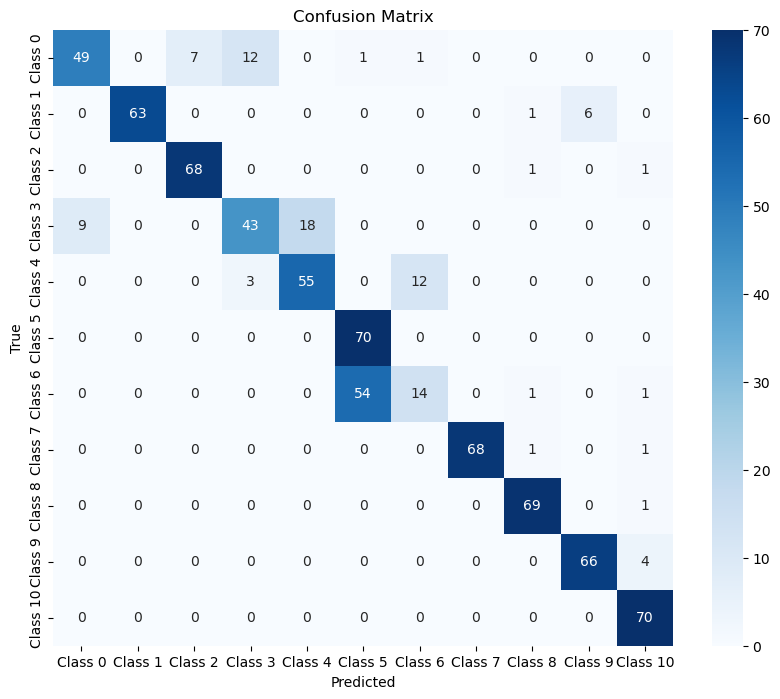

In [28]:
# Evaluate the model on test data
print("Evaluating the model on test data...")
evaluate_model_percentage(model, test_loader, device, num_classes)

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne_embeddings(model, loader, device, class_to_idx):
    """
    Visualize embeddings using t-SNE.

    Args:
        model: Trained model to generate embeddings.
        loader: DataLoader for the data to be visualized.
        device: Device to run the model on.
        class_to_idx: Mapping of class names to indices.
    """
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model.forward_once(inputs).cpu().numpy()  # Convert to NumPy array
            embeddings.append(outputs)
            labels.extend(targets.cpu().numpy())

    # Convert list of arrays to a single NumPy array
    embeddings = np.vstack(embeddings)  # Ensure it’s a 2D array

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the 2D t-SNE embeddings
    plt.figure(figsize=(10, 8))
    for class_idx in np.unique(labels):
        idxs = np.where(np.array(labels) == class_idx)[0]
        plt.scatter(
            embeddings_2d[idxs, 0],
            embeddings_2d[idxs, 1],
            label=f"Class {class_idx}",
            alpha=0.6
        )
    plt.legend()
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

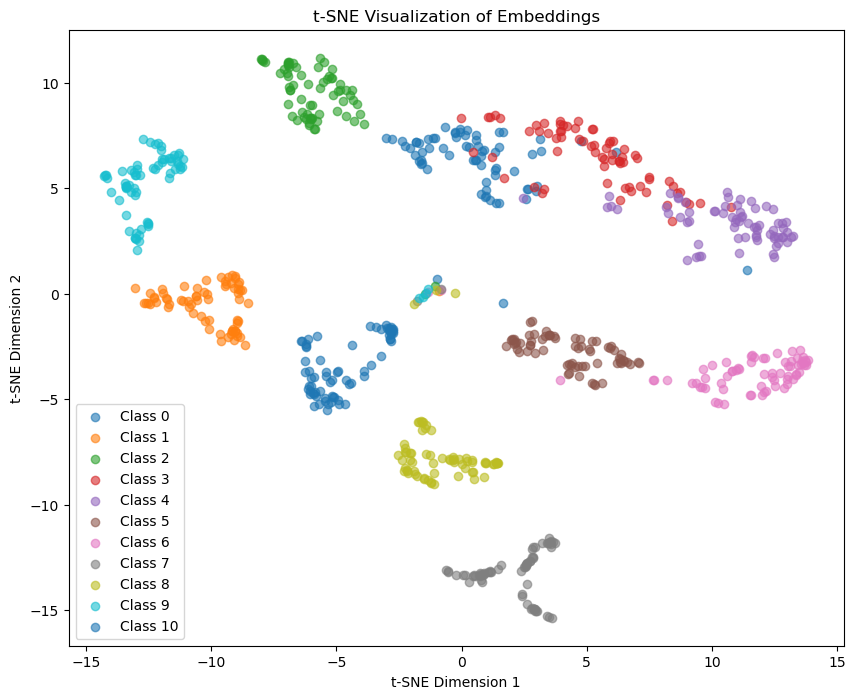

In [30]:
visualize_tsne_embeddings(model, test_loader, device, class_to_idx)